In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# EDA

In [15]:
train_df = pd.read_csv('../data/train_data.csv', header=None, dtype=float)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


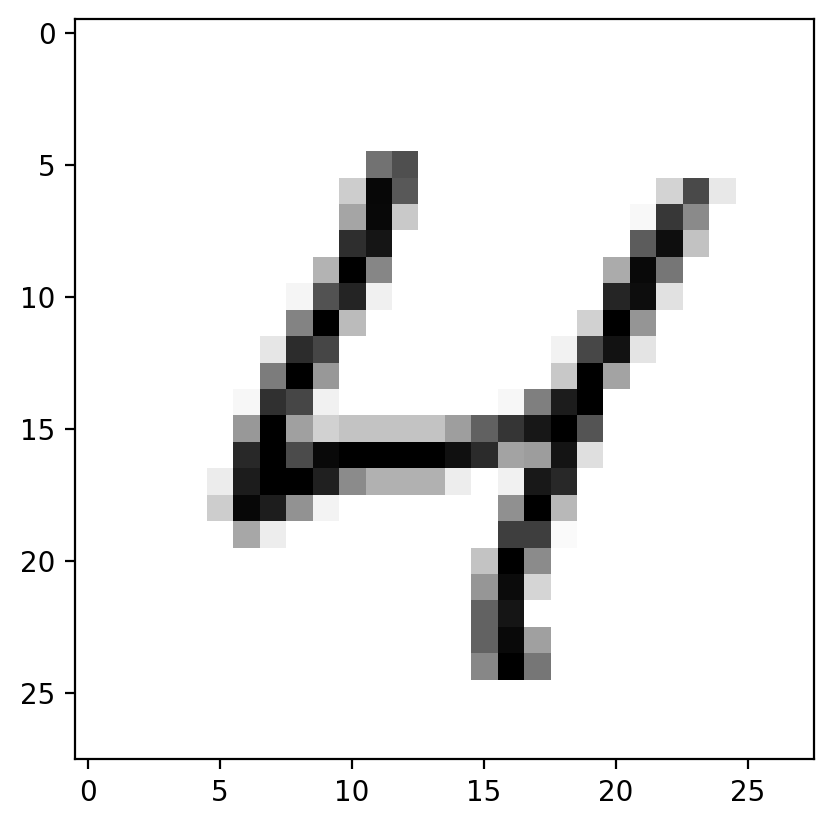

In [16]:
sample = 42

plt.imshow(
  train_df.iloc[sample, 1:].values.reshape(28, 28), 
  cmap='gray_r'
)

plt.show()

In [17]:
print(
  f'max: {train_df.iloc[:, 1:].to_numpy().max()}\n',
  f'min: {train_df.iloc[:, 1:].to_numpy().min()}\n',
  f'avg: {train_df.iloc[:, 1:].to_numpy().mean()}\n',
  f'mod: {np.percentile(train_df.iloc[:, 1:].to_numpy(), 50)}'
)

max: 255.0
 min: 0.0
 avg: 33.32952576530612
 mod: 0.0


In [18]:
test_df = pd.read_csv('../data/test_data.csv', header=None, dtype=float)

train_mean = train_df.values[:, 1:].mean()
train_std = train_df.values[:, 1:].std()

print(f'train_mean={train_mean:.2f}, train_std={train_std:.2f}')

train_df.values[:, 1:] -= train_mean
train_df.values[:, 1:] /= train_std
test_df.values[:, 1:] -= train_mean
test_df.values[:, 1:] /= train_std
  
np.save('../data/train_data.npy', train_df)
np.save('../data/test_data.npy', test_df)

train_mean=33.33, train_std=78.58


# Training

In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics

In [20]:
class MNISTDatasetCsv(Dataset):
  def __init__(self, path: str):
    data = np.load(path)
    self.data = torch.tensor(data[:, 1:]).float().reshape(data.shape[0], 1, 28, 28)
    self.labels = torch.tensor(data[:, 0]).long()

  def __len__(self) -> int:
    return self.labels.shape[0]

  def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
    return self.data[index], self.labels[index]

In [21]:
class MNISTClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
    self.relu2 = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(16*24*24, 10)

  def forward(self, x: torch.Tensor):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.flatten(x)
    x = self.linear(x)
    return x

In [22]:
loss_fn = nn.CrossEntropyLoss()
metric_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10)
model = MNISTClassifier()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [23]:
dataset = MNISTDatasetCsv('../data/train_data.npy')

train_size = int(.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [25]:
import mlflow
from mlflow.models import infer_signature, ModelSignature
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from tqdm.notebook import tqdm as progress

train_step = 0
test_step = 0
epochs = 3
best_loss = float('inf')
num_batches = len(train_dataloader)-1

with mlflow.start_run():

  mlflow.log_params({
    'loss_function': 'CrossEntropyLoss',
    'metric_function': 'Accuracy',
    'optimizer_class': 'SGD',
    'batch_size': 128,
    'epochs': 3,
    'lr': .01,
  })

  for e in range(epochs):
    print(f'ecpoch {e}:')
    # Тренировочный цикл
    model.train()
    for X, y in progress(train_dataloader, total=len(train_dataloader), desc='Train'):
      pred = model(X)
      loss = loss_fn(pred, y)
      accuracy = metric_fn(pred, y)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss = loss.item()
      mlflow.log_metric('train_loss', loss, step=train_step)
      mlflow.log_metric('train_accuracy', accuracy, step=train_step)
      train_step += 1

    # Валидационный цикл
    model.eval()
    with torch.no_grad():
      for X, y in progress(val_dataloader, total=len(val_dataloader), desc='Val'):
        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = metric_fn(pred, y)

        loss = loss.item()
        mlflow.log_metric('val_loss', loss, step=test_step)
        mlflow.log_metric('val_accuracy', accuracy, step=test_step)
        test_step += 1
    
  # Тестирование на отложенной выборке
  test_data = np.load('../data/test_data.npy')
  X = torch.tensor(test_data[:, 1:]).float().reshape(test_data.shape[0], 1, 28, 28)
  y = torch.tensor(test_data[:, 0]).long()

  model.eval()
  with torch.no_grad():
    pred = model(X)
    loss = loss_fn(pred, y)
    accuracy = metric_fn(pred, y)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('accuracy', accuracy)

Exception: '/Users/peter/Projects/otus/mlops/open_lessons/otus_ol_mlops_prod/notebooks/mlruns' does not exist.